In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import AutoARIMA, ARIMA
from darts.metrics import mape, mae, rmse
import matplotlib.pyplot as plt

/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the business demand data
BD = pd.read_csv("Business_demand_trends_20240901140306.csv")

# Remove the first 9 rows
BD = BD.iloc[9:].reset_index(drop=True)

# Convert 'Period start' to datetime format
BD['Period start'] = pd.to_datetime(BD['Period start'], format='%d/%m/%y')

# Filter by a specific "Region ID", for instance "CNI" (Central North Island) – adjust as needed
region_id = "CNI"  # Replace with the desired "Region ID"
BD_region = BD[BD['Region ID'] == region_id]

# Set 'Period start' as the index
BD_region.set_index('Period start', inplace=True)

# Convert to a Darts TimeSeries object, selecting "Est. Total consumption (GWh)" as the target variable
series = TimeSeries.from_series(BD_region['Selected business demand (GWh)'])

In [3]:
# Define training series (pre-2018) and validation series (2018-2019)
train_series = series.slice(pd.Timestamp('2010-01-01'), pd.Timestamp('2017-12-31'))
validation_series = series.slice(pd.Timestamp('2018-01-01'), pd.Timestamp('2024-06-01'))

In [5]:
# Initialize SARIMA model with (0, 1, 2)x(0, 1, 1, 12)
sarima_model = ARIMA(0, 1, 2, seasonal_order=(0, 1, 1, 12))

In [5]:
# Conduct backtesting on pre-COVID data (2018-2019)
print("Backtesting SARIMA Model (0, 1, 2)x(0, 1, 1, 12)")

backtest_mape = sarima_model.backtest(
    series=series,
    start=pd.Timestamp('2018-01-01'),
    forecast_horizon=3,
    stride=1,
    metric=mape,
    train_length=None,
    retrain=True
)

print(f"MAPE for SARIMA (0, 1, 2)x(0, 1, 1, 12) during backtesting: {backtest_mape}")

Backtesting SARIMA Model (0, 1, 2)x(0, 1, 1, 12)
MAPE for SARIMA (0, 1, 2)x(0, 1, 1, 12) during backtesting: 3.5616329395446855


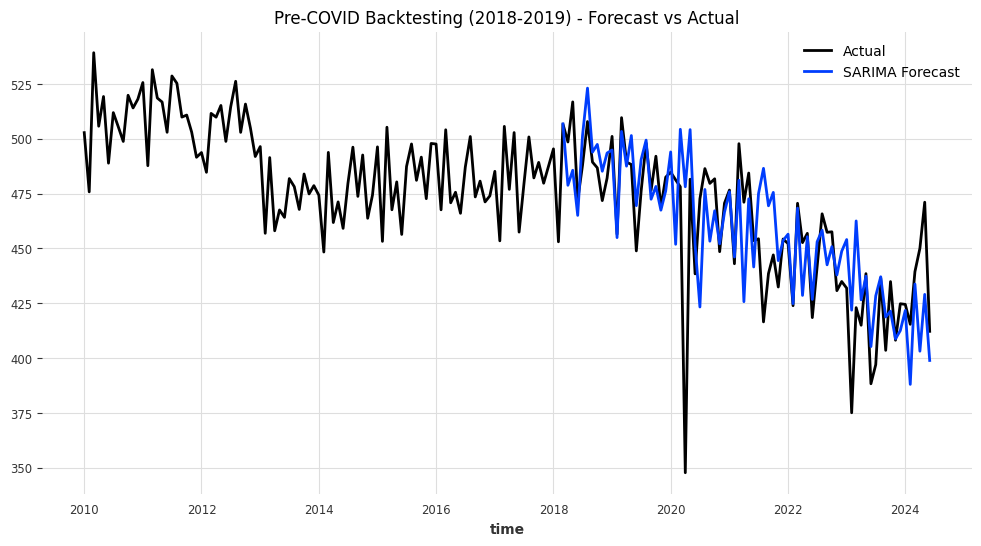

In [6]:
# Generate historical forecasts for visualization
forecast_sarima = sarima_model.historical_forecasts(
    series=series,
    start=pd.Timestamp('2018-01-01'),
    forecast_horizon=3,
    stride=1,
    retrain=True
)

# Plot actual vs. forecast
plt.figure(figsize=(12, 6))
series.plot(label="Actual")
forecast_sarima.plot(label="SARIMA Forecast")
plt.legend()
plt.title("Pre-COVID Backtesting (2018-2019) - Forecast vs Actual")
plt.show()

In [7]:
# Convert forecasted values to a pandas DataFrame
backtest_pred = forecast_sarima.pd_dataframe()

# Rename the prediction column
backtest_pred.rename(columns={backtest_pred.columns[0]: "predictions"}, inplace=True)

# Define the validation period (2018-2024)
validation_series = series.slice(pd.Timestamp('2018-01-01'), pd.Timestamp('2024-06-01'))

# Join the validation data (actual values) with the forecasted predictions
backtest_pred = backtest_pred.join(validation_series.pd_dataframe(), how='inner')

# Rename the actual values column
backtest_pred.rename(columns={backtest_pred.columns[1]: "actual"}, inplace=True)

# Calculate the difference between actual and predictions
backtest_pred['difference'] = backtest_pred['predictions'] - backtest_pred['actual']

#backtest_pred.head()

In [8]:
# Save the output to a CSV file
backtest_pred.to_csv('SARIMA,CNI,bus.csv', index=True)

In [8]:
# Calculate metrics: MAPE, RMSE, and MAE
mape_value = mape(validation_series, forecast_sarima)
rmse_value = rmse(validation_series, forecast_sarima)
mae_value = mae(validation_series, forecast_sarima)

# Print out the results
print(f"MAPE: {mape_value:.4f}")
print(f"RMSE: {rmse_value:.4f}")
print(f"MAE: {mae_value:.4f}")

MAPE: 3.8006
RMSE: 25.2786
MAE: 16.5876
